In [3]:
import json
import pandas as pd

# File path to the log file
log_file_path = "/Users/vatsal/Desktop/SimplyTag/orgadata-st0.log"
output_csv_path = "/Users/vatsal/Desktop/converted_logs.csv"

# Initialize a list to store JSON data
log_data = []

# Read the log file line by line
with open(log_file_path, "r") as file:
    for line in file:
        # Find the JSON part of each line
        json_start = line.find('{')
        if json_start != -1:
            json_data = line[json_start:].strip()
            try:
                # Parse the JSON and append it to the list
                log_data.append(json.loads(json_data))
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {json_data}")

# Convert the list of JSON objects to a DataFrame
df = pd.DataFrame(log_data)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f"Log data successfully converted to CSV and saved at {output_csv_path}")


Log data successfully converted to CSV and saved at /Users/vatsal/Desktop/converted_logs.csv


In [4]:
print(df.columns)


Index(['Level', 'Timestamp', 'PID', 'Logger', 'Message', 'Scope',
       'Application', 'State', 'EventId', 'Exception'],
      dtype='object')


In [7]:
# Check if 'State' column contains dictionaries
print(df['State'].iloc[0])  # Print the first entry for verification

# Extract specific fields directly from 'State'
df['Trace-id'] = df['Scope'].apply(lambda x: x.get('TraceId') if isinstance(x, dict) else None)
df['HTTP Status Code'] = df['State'].apply(lambda x: x.get('StatusCode') if isinstance(x, dict) else None)
df['Path'] = df['State'].apply(lambda x: x.get('Path') if isinstance(x, dict) else None)
df['User Agent'] = df['State'].apply(lambda x: x.get('User-Agent') if isinstance(x, dict) else None)

# Print columns to verify
print(df[['Trace-id', 'HTTP Status Code', 'Path', 'User Agent']].head())


{'Protocol': 'HTTP/1.1', 'Method': 'GET', 'ContentType': None, 'ContentLength': None, 'Scheme': 'http', 'Host': 'api.owds.org', 'PathBase': '', 'Path': '/api/healthz', 'QueryString': '', '{OriginalFormat}': 'Request starting {Protocol} {Method} {Scheme}://{Host}{PathBase}{Path}{QueryString} - {ContentType} {ContentLength}'}
                           Trace-id  HTTP Status Code          Path  \
0  c012824f5c58bedb5fcd9ac2bb08de69               NaN  /api/healthz   
1  c012824f5c58bedb5fcd9ac2bb08de69               NaN  /api/healthz   
2  c012824f5c58bedb5fcd9ac2bb08de69               NaN          None   
3  60d518ec273ea0e4c19e010a213f446d               NaN  /api/healthz   
4  60d518ec273ea0e4c19e010a213f446d               NaN  /api/healthz   

   User Agent  
0        None  
1  curl/8.5.0  
2        None  
3        None  
4  curl/8.5.0  


In [8]:
# Filter for relevant columns
relevant_data = df[['Trace-id', 'Message', 'Path', 'User Agent', 'HTTP Status Code', 'Timestamp']]
relevant_data.isnull().sum()

Trace-id                 0
Message                  0
Path                190373
User Agent          239622
HTTP Status Code    212022
Timestamp                0
dtype: int64

In [26]:
# Create a copy of the relevant data to avoid SettingWithCopyWarning
relevant_data = relevant_data.copy()

# Extract HTTP methods and paths from 'Message' (example; adjust per data structure)
relevant_data['HTTP_Method'] = relevant_data['Message'].str.extract(r'(GET|POST|PUT|DELETE)')
relevant_data['Endpoint'] = relevant_data['Message'].str.extract(r'(http[s]?://[^\s]+)')  # Added capturing group

# Handle missing values
relevant_data.fillna("Unknown", inplace=True)


In [27]:
# Convert 'HTTP Status Code' to integer, handling any errors gracefully
relevant_data['HTTP Status Code'] = pd.to_numeric(relevant_data['HTTP Status Code'], errors='coerce')

# Categorize HTTP status codes
relevant_data['Status_Category'] = relevant_data['HTTP Status Code'].apply(
    lambda x: 'Breach' if x == 200 else 'Success' if 200 < x < 300 else 'Client Error' if 400 <= x < 500 else 'Server Error' if 500 <= x < 600 else 'Other'
)

# Flag suspicious activities (flag 200 status codes as suspicious for now, adjust as per your logic)
relevant_data['Is_Suspicious'] = relevant_data['HTTP Status Code'] == 200

# Show the new column for suspicious activities
print(relevant_data['Is_Suspicious'])


0         False
1         False
2         False
3         False
4         False
          ...  
263093    False
263094    False
263095    False
263096    False
263097     True
Name: Is_Suspicious, Length: 263098, dtype: bool


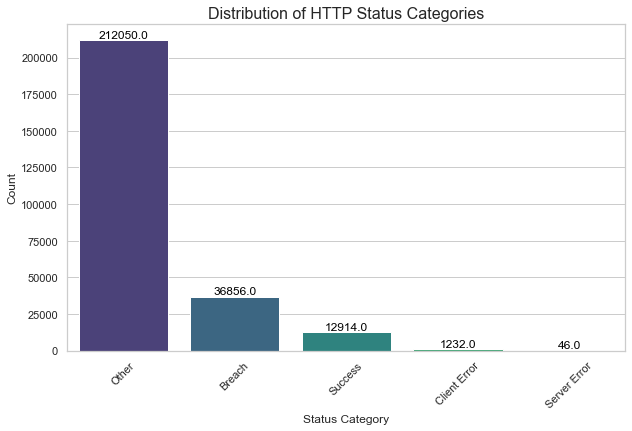

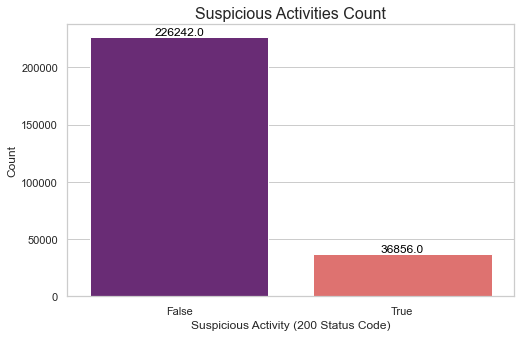

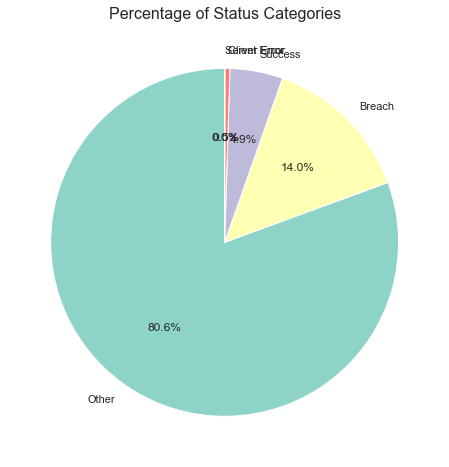

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better aesthetics
sns.set(style="whitegrid")

# 1. Plot the distribution of status categories
plt.figure(figsize=(10, 6))
status_counts = relevant_data['Status_Category'].value_counts()
ax = sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of HTTP Status Categories', fontsize=16)
plt.xlabel('Status Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 2. Plot the count of suspicious activities
plt.figure(figsize=(8, 5))
suspicious_counts = relevant_data['Is_Suspicious'].value_counts()
ax = sns.barplot(x=suspicious_counts.index, y=suspicious_counts.values, palette='magma')

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Suspicious Activities Count', fontsize=16)
plt.xlabel('Suspicious Activity (200 Status Code)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

# 3. Create a pie chart for the status category distribution
plt.figure(figsize=(8, 8))
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", n_colors=len(status_counts)))

# Add labels on the pie chart sectors
plt.title('Percentage of Status Categories', fontsize=16)
plt.ylabel('')  # Hide the ylabel for better presentation
plt.show()


In [29]:
print(f"There are total {relevant_data['HTTP Status Code'].count()} HTTP Status Code"  )

There are total 51076 HTTP Status Code


In [30]:
# Get the number of unique HTTP status codes in your dataset
unique_status_codes = relevant_data['HTTP Status Code'].nunique()

print(f"There are {unique_status_codes} different HTTP status codes in the data.")


There are 14 different HTTP status codes in the data.


In [31]:
# Display the unique HTTP status codes
unique_status_codes_list = relevant_data['HTTP Status Code'].unique()

print("Unique HTTP Status Codes:", unique_status_codes_list)


Unique HTTP Status Codes: [ nan 200. 404. 503. 401. 204. 201. 409.   0. 400. 415. 499. 202. 500.
 403.]


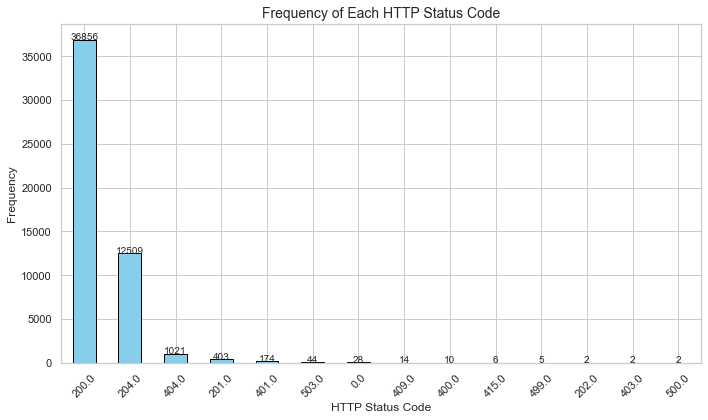

In [32]:
# Count the occurrences of each HTTP status code
status_code_counts = relevant_data['HTTP Status Code'].value_counts()

# Plot a bar graph for the HTTP status codes and their frequencies
plt.figure(figsize=(10, 6))
status_code_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Frequency of Each HTTP Status Code', fontsize=14)
plt.xlabel('HTTP Status Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the frequency count on top of each bar
for i, v in enumerate(status_code_counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
relevant_data['HTTP Status Code'].value_counts()

200.0    36856
204.0    12509
404.0     1021
201.0      403
401.0      174
503.0       44
0.0         28
409.0       14
400.0       10
415.0        6
499.0        5
202.0        2
403.0        2
500.0        2
Name: HTTP Status Code, dtype: int64

In [34]:
import re

# Extract potential HTTP status codes from the 'Message' column
relevant_data['Extracted_Status_Code'] = relevant_data['Message'].apply(
    lambda x: re.search(r'\b\d{3}\b', x).group() if re.search(r'\b\d{3}\b', x) else None
)

# Convert the extracted codes to numeric (to filter out non-status codes)
relevant_data['Extracted_Status_Code'] = pd.to_numeric(relevant_data['Extracted_Status_Code'], errors='coerce')


In [39]:
status_code_counts = relevant_data['Extracted_Status_Code'].unique()
print(status_code_counts)


[ nan 200. 709. 538. 333. 379. 923. 431. 399. 348. 895. 372. 490. 345.
 516. 693. 463. 498. 494. 476. 499. 558. 553. 621. 981. 609. 398. 343.
 392. 512. 384. 403. 338. 454. 634. 358. 328. 391. 357. 322. 458. 361.
 362. 350. 376. 364. 475. 363. 415. 460. 432. 329. 493. 346. 418. 351.
 324. 513. 430. 354. 557. 325. 597. 457. 353. 804. 397. 440. 612. 442.
 469. 633. 715. 542. 544. 561. 407. 646. 414. 563. 810. 624. 757. 365.
 423. 405. 378. 662. 406. 316. 429. 578. 420. 506. 389. 453. 564. 481.
 579. 478. 382. 521. 459. 422. 610. 374. 445. 404. 416. 352. 602. 411.
 393. 584. 480. 565. 395. 387. 443. 511. 377. 491. 631. 344. 527. 323.
 349. 368. 590. 413. 468. 674. 380. 367. 686. 667. 400. 543. 466. 567.
 593. 371. 373. 789. 369. 588. 447. 575. 381. 517. 496. 335. 332. 434.
 339. 501. 530. 552. 510. 451. 479. 455. 489. 571. 801. 482. 546. 385.
 425. 394. 526. 698. 883. 438. 523. 568. 705. 658. 613. 555. 817. 465.
 556. 793. 635. 778. 370. 620. 607. 535. 396. 302. 525. 547. 388. 331.
 366. 

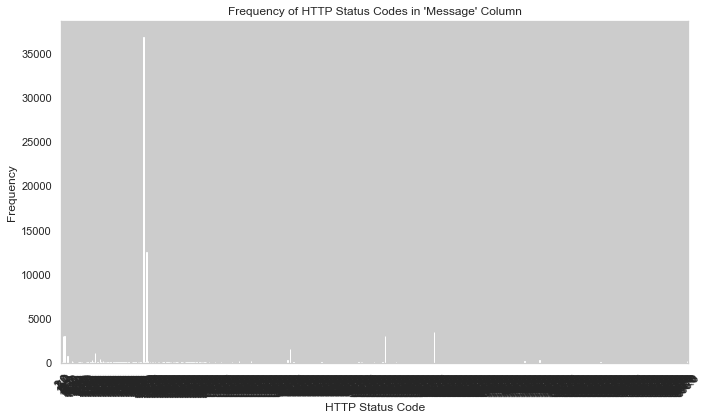

In [38]:
import matplotlib.pyplot as plt

# Drop NaN values and plot
status_code_counts.dropna().sort_index().plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.title("Frequency of HTTP Status Codes in 'Message' Column")
plt.xlabel("HTTP Status Code")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Index(['Trace-id', 'Message', 'Path', 'User Agent', 'HTTP Status Code',
       'Timestamp', 'HTTP_Method', 'Endpoint', 'Status_Category',
       'Is_Suspicious', 'Extracted_Status_Code'],
      dtype='object')


KeyError: 'Scope'

In [52]:
Trace_id_different = relevant_data['Trace-id'].nunique()
print(Trace_id_different)

24218


In [53]:
Trace_id_count = relevant_data['Trace-id'].value_counts()
print(Trace_id_count)

046b42d022083f3c07e46f6e41cd05f9    55
0ee4f32a94335609bcac0d82419d0c7c    44
627203bdd0b630fe435c2badac0ebc70    42
f00ad553da7d7553eac70c53afdc992a    38
23b0323eee6bcf3addfc406ba7c8e845    38
                                    ..
6a73a04f74effc6386d9749eab74d57b     4
bc858a16476e0823f753b8026bfac291     4
c24a8beaae42fc457320065f24fc1d12     3
6f7d3891e16e85d58207458564407ed2     1
9c19b84c509db21024c921adaa3c0f05     1
Name: Trace-id, Length: 24218, dtype: int64


In [54]:
# Group by 'Trace-id' and collect associated status codes
trace_status = relevant_data.groupby('Trace-id')['HTTP Status Code'].apply(list).reset_index()

# Rename columns for clarity
trace_status.columns = ['Trace-id', 'Associated Status Codes']

# Display trace IDs with their associated status codes
print(trace_status)

# Identify trace IDs without associated status codes (if any are null or empty)
missing_status = trace_status[trace_status['Associated Status Codes'].apply(len) == 0]
print("Trace IDs without associated status codes:")
print(missing_status)


                               Trace-id  \
0      0000ca9c0504724ec0352caf2d927e26   
1      0001693fd167addef160ab0dddfb31d8   
2      0001d8ca5b76e77d80a9a3ec83903f7d   
3      0006743a3d496bd092ebc52c3d0b8791   
4      0006891837e1c59dbd11546003c786df   
...                                 ...   
24213  ffee5ded9b0944613c41e0cddb213165   
24214  fff376108641b89f77934773cfa9ead8   
24215  fffb37a93fcf4db1abf19f01c54e891c   
24216  fffbccd1228e81edfd22b2f63878fe11   
24217  fffddf260aed4d430f3e5a7bf6be14a5   

                                 Associated Status Codes  
0                     [nan, nan, nan, 204.0, nan, 204.0]  
1      [nan, nan, nan, nan, nan, nan, nan, nan, 200.0...  
2                     [nan, nan, nan, 204.0, nan, 204.0]  
3                     [nan, nan, nan, 204.0, nan, 204.0]  
4      [nan, nan, nan, nan, nan, nan, nan, 200.0, nan...  
...                                                  ...  
24213  [nan, nan, nan, nan, nan, nan, nan, nan, 200.0...  
24214  [nan

In [73]:
# Filter rows where HTTP Status Code is 200
status_200_data = relevant_data[relevant_data['HTTP Status Code'] == 200]

# Select the relevant columns: 'Trace-id' and 'Path'
status_200_table = status_200_data[['Trace-id', 'Path']]

# Display the table
print(status_200_table)

# (Optional) Save the table to a file
status_200_table.to_csv("status_200_trace_path.csv", index=False)


                                Trace-id              Path
9       60d518ec273ea0e4c19e010a213f446d           Unknown
13      60d518ec273ea0e4c19e010a213f446d      /api/healthz
14      e7089e4e5f6172199898d944f4eecb2d           Unknown
15      c012824f5c58bedb5fcd9ac2bb08de69           Unknown
19      c012824f5c58bedb5fcd9ac2bb08de69      /api/healthz
...                                  ...               ...
263071  d60a0fa2eeef9985449391d3a3c619a8      /api/healthz
263079  c04e0c475d8a6a9e673f00ae3bb74e41           Unknown
263084  c04e0c475d8a6a9e673f00ae3bb74e41  /api/v2/versions
263092  e633e492116f3febe619bfed47449e89           Unknown
263097  e633e492116f3febe619bfed47449e89  /api/v2/versions

[36856 rows x 2 columns]


In [74]:
status_200_data[['Trace-id', 'Path']].value_counts()

Trace-id                          Path            
046b42d022083f3c07e46f6e41cd05f9  Unknown             21
627203bdd0b630fe435c2badac0ebc70  Unknown             15
0ee4f32a94335609bcac0d82419d0c7c  Unknown             14
5347038900432646491cce6490137bf9  Unknown             13
e3e24eff73a1dc04661569b0cf84bfdc  Unknown             13
                                                      ..
59458de496f9fa1ebc5835d4c176744a  /api/v2/versions     1
59421904a921d36eec42533c9823a85a  Unknown              1
                                  /api/v2/versions     1
5940fa2e99aa9df0356cbc8f2f4bbbde  Unknown              1
fffddf260aed4d430f3e5a7bf6be14a5  Unknown              1
Length: 34296, dtype: int64

In [75]:
relevant_data[relevant_data['HTTP Status Code'] == 200].nunique()

Trace-id                 17153
Message                  20342
Path                      1640
User Agent                   1
HTTP Status Code             1
Timestamp                36856
HTTP_Method                  3
Endpoint                  1875
Status_Category              1
Is_Suspicious                1
Extracted_Status_Code       51
dtype: int64

In [78]:
# Filter rows where the HTTP Status Code is 404
table_200 = relevant_data[relevant_data['HTTP Status Code'] == 200][['Trace-id', 'Message', 'Path']]

# Display the table
print(table_200)


                                Trace-id  \
9       60d518ec273ea0e4c19e010a213f446d   
13      60d518ec273ea0e4c19e010a213f446d   
14      e7089e4e5f6172199898d944f4eecb2d   
15      c012824f5c58bedb5fcd9ac2bb08de69   
19      c012824f5c58bedb5fcd9ac2bb08de69   
...                                  ...   
263071  d60a0fa2eeef9985449391d3a3c619a8   
263079  c04e0c475d8a6a9e673f00ae3bb74e41   
263084  c04e0c475d8a6a9e673f00ae3bb74e41   
263092  e633e492116f3febe619bfed47449e89   
263097  e633e492116f3febe619bfed47449e89   

                                                  Message              Path  
9       Response:\nStatusCode: 200\nContent-Type: appl...           Unknown  
13      Request finished HTTP/1.1 GET http://api.owds....      /api/healthz  
14      Response:\nStatusCode: 200\nContent-Type: appl...           Unknown  
15      Response:\nStatusCode: 200\nContent-Type: appl...           Unknown  
19      Request finished HTTP/1.1 GET http://api.owds....      /api/healthz  
...

In [80]:
# Saving the filtered table to an Excel file
table_200.to_excel('/Users/vatsal/Desktop/trace_id_200_status_code.xlsx', index=False)


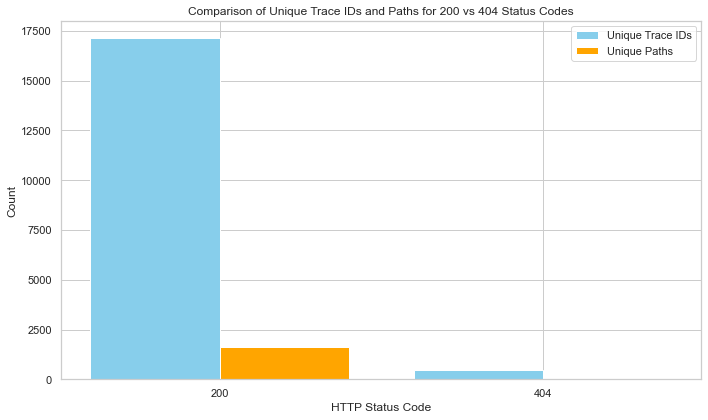

In [81]:
import matplotlib.pyplot as plt

# Filter data for 200 and 404 status codes
data_200 = relevant_data[relevant_data['HTTP Status Code'] == 200]
data_404 = relevant_data[relevant_data['HTTP Status Code'] == 404]

# Count unique trace IDs and paths
comparison_data = {
    'Status Code': ['200', '404'],
    'Unique Trace IDs': [data_200['Trace-id'].nunique(), data_404['Trace-id'].nunique()],
    'Unique Paths': [data_200['Path'].nunique(), data_404['Path'].nunique()]
}

# Create a DataFrame for visualization
comparison_df = pd.DataFrame(comparison_data)

# Plot the grouped bar chart
x = range(len(comparison_df))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, comparison_df['Unique Trace IDs'], width, label='Unique Trace IDs', color='skyblue')
plt.bar([i + width for i in x], comparison_df['Unique Paths'], width, label='Unique Paths', color='orange')

# Add labels and title
plt.xticks([i + width / 2 for i in x], comparison_df['Status Code'])
plt.xlabel('HTTP Status Code')
plt.ylabel('Count')
plt.title('Comparison of Unique Trace IDs and Paths for 200 vs 404 Status Codes')
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# File path to the merged CSV
input_csv_path = "/Users/vatsal/Desktop/SimplyTag/merged_logs.csv"
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/selected_data.csv"

# Load the merged CSV into a DataFrame
df = pd.read_csv(input_csv_path)

# Display the first few rows to inspect the data structure
print("Initial DataFrame Structure:\n", df.head())

# Columns to retain for analysis
columns_to_select = ['trace_id', 'status_code', 'path', 'user_agent', 'timestamp']

# Select only the necessary columns
if set(columns_to_select).issubset(df.columns):
    selected_df = df[columns_to_select]
else:
    missing_columns = set(columns_to_select) - set(df.columns)
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Display the selected DataFrame
print("Selected Columns DataFrame:\n", selected_df.head())

# Save the selected data to a new CSV file
selected_df.to_csv(output_csv_path, index=False)
print(f"Selected data has been saved to {output_csv_path}")


/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Initial DataFrame Structure:
   Level                     Timestamp  PID  \
0  INFO  2024-11-29T23:00:22.7045112Z  668   
1  INFO  2024-11-29T23:00:22.7065968Z  668   
2  INFO  2024-11-29T23:00:22.7104302Z  668   
3  INFO  2024-11-29T23:00:22.7112929Z  668   
4  INFO  2024-11-29T23:00:22.7124052Z  668   

                                              Logger  \
0           Microsoft.AspNetCore.Hosting.Diagnostics   
1  Microsoft.AspNetCore.HttpLogging.HttpLoggingMi...   
2    Microsoft.AspNetCore.Routing.EndpointMiddleware   
3  Microsoft.AspNetCore.Mvc.Infrastructure.Contro...   
4  Microsoft.AspNetCore.Mvc.Infrastructure.Contro...   

                                             Message  \
0  Request starting HTTP/1.1 GET http://api.owds....   
1  Request:\nProtocol: HTTP/1.1\nMethod: GET\nSch...   
2  Executing endpoint 'Ofcas.Datasafe.WebApi.Cont...   
3  Route matched with {action = "GetApiVersionsV2...   
4  Executing action method Ofcas.Datasafe.WebApi....   

                   

ValueError: The following required columns are missing in the dataset: {'trace_id', 'path', 'status_code', 'user_agent', 'timestamp'}

In [4]:
import pandas as pd

# File path to the merged CSV
input_csv_path = "/Users/vatsal/Desktop/SimplyTag/merged_logs.csv"
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/selected_data.csv"

# Load the CSV file with low_memory=False to avoid DtypeWarning
df = pd.read_csv(input_csv_path, low_memory=False)

# Display the column names to inspect
print("Available Columns:\n", df.columns)

# Clean column names (strip leading/trailing whitespaces and convert to lowercase)
df.columns = df.columns.str.strip().str.lower()

# Standardized column names for selection
columns_to_select = ['trace_id', 'status_code', 'path', 'user_agent', 'timestamp']

# Check if required columns are present
if set(columns_to_select).issubset(df.columns):
    selected_df = df[columns_to_select]
else:
    missing_columns = set(columns_to_select) - set(df.columns)
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Display the selected data
print("Selected Columns DataFrame:\n", selected_df.head())

# Save the selected data to a new CSV file
selected_df.to_csv(output_csv_path, index=False)
print(f"Selected data has been saved to {output_csv_path}")


Available Columns:
 Index(['Level', 'Timestamp', 'PID', 'Logger', 'Message', 'Scope',
       'Application', 'State', 'EventId', 'Exception'],
      dtype='object')


ValueError: The following required columns are missing in the dataset: {'status_code', 'user_agent', 'path', 'trace_id'}

In [11]:
import pandas as pd
import json

# File path to the merged CSV
input_csv_path = "/Users/vatsal/Desktop/SimplyTag/merged_logs.csv"
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/selected_data.csv"

# Load the CSV file with low_memory=False to avoid DtypeWarning
df = pd.read_csv(input_csv_path, low_memory=False)

# Inspect one entry to verify the structure of nested JSON
print("Sample Entry:\n", df.iloc[0])


# Extract specific fields directly from 'State'
df['Trace-id'] = df['Scope'].apply(lambda x: x.get('TraceId') if isinstance(x, dict) else None)
df['HTTP Status Code'] = df['State'].apply(lambda x: x.get('StatusCode') if isinstance(x, dict) else None)
df['Path'] = df['State'].apply(lambda x: x.get('Path') if isinstance(x, dict) else None)
df['User Agent'] = df['State'].apply(lambda x: x.get('UserAgent') if isinstance(x, dict) else None)

# Print columns to verify
print(df[['Trace-id', 'HTTP Status Code', 'Path', 'User Agent']].head())


# Attempt to extract fields from nested JSON in relevant columns
# Adjust these field names ('State', 'Scope') as per your dataset structure
#df['trace_id'] = df['Scope'].apply(lambda x: json.loads(x).get('TraceId') if isinstance(x, str) else None)
#df['status_code'] = df['State'].apply(lambda x: json.loads(x).get('StatusCode') if isinstance(x, str) else None)
#df['path'] = df['State'].apply(lambda x: json.loads(x).get('Path') if isinstance(x, str) else None)
#df['user_agent'] = df['State'].apply(lambda x: json.loads(x).get('UserAgent') if isinstance(x, str) else None)
#df['timestamp'] = df['State'].apply(lambda x: json.loads(x).get('Timestamp') if isinstance(x, str) else None)

# Check if all required fields are extracted
print("Extracted Data:\n", df[['Timestamp', 'Trace-id', 'HTTP Status Code', 'Path', 'User Agent']].head())

# Drop any rows where critical fields are missing (optional)
#df_cleaned = df.dropna(subset=['trace_id', 'status_code', 'path', 'user_agent', 'timestamp'])

# Save the selected data to a new CSV file
df[['Timestamp', 'Trace-id', 'HTTP Status Code', 'Path', 'User Agent', 'Timestamp']].to_csv(output_csv_path, index=False)
print(f"Selected data has been saved to {output_csv_path}")


Sample Entry:
 Level                                                       INFO
Timestamp                           2024-11-29T23:00:22.7045112Z
PID                                                          668
Logger                  Microsoft.AspNetCore.Hosting.Diagnostics
Message        Request starting HTTP/1.1 GET http://api.owds....
Scope          {'ParentId': '0000000000000000', 'ConnectionId...
Application    {'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...
State          {'Protocol': 'HTTP/1.1', 'Method': 'GET', 'Con...
EventId                                  {'Id': 1, 'Name': None}
Exception                                                    NaN
Name: 0, dtype: object
  Trace-id HTTP Status Code  Path User Agent
0     None             None  None       None
1     None             None  None       None
2     None             None  None       None
3     None             None  None       None
4     None             None  None       None
Extracted Data:
                       Tim

In [1]:
import os

# Folder path containing all .log files
folder_path = "/Users/vatsal/Desktop/SimplyTag"  # Replace with your folder path
combined_log_file = "/Users/vatsal/Desktop/SimplyTag/combined_logs.log"

# Open the combined log file in write mode
with open(combined_log_file, "w") as outfile:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".log"):  # Check if the file is a .log file
            log_file_path = os.path.join(folder_path, file_name)
            print(f"Adding file: {log_file_path}")
            
            # Open each log file and append its content to the combined file
            with open(log_file_path, "r") as infile:
                outfile.write(infile.read())
                outfile.write("\n")  # Add a newline for separation
print(f"All .log files combined into: {combined_log_file}")


Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st8.log
Adding file: /Users/vatsal/Desktop/SimplyTag/combined_logs.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st4.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st5.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st7.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st6.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st2.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st3.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st1.log
Adding file: /Users/vatsal/Desktop/SimplyTag/orgadata-st0.log
All .log files combined into: /Users/vatsal/Desktop/SimplyTag/combined_logs.log


In [2]:
import json
import pandas as pd

# Path to the combined log file and output CSV file
combined_log_file = "/Users/vatsal/Desktop/SimplyTag/combined_logs.log"
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/combined_logs.csv"

# Initialize a list to store JSON data
log_data = []

# Read the combined log file line by line
with open(combined_log_file, "r") as file:
    for line in file:
        # Find the JSON part of each line
        json_start = line.find('{')
        if json_start != -1:
            json_data = line[json_start:].strip()
            try:
                # Parse the JSON and append it to the list
                log_data.append(json.loads(json_data))
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {json_data}")

# Convert the list of JSON objects to a DataFrame
if log_data:
    df = pd.DataFrame(log_data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_path, index=False)
    print(f"Combined log data successfully converted to CSV and saved at {output_csv_path}")
else:
    print("No valid log entries found in the combined log file.")


Combined log data successfully converted to CSV and saved at /Users/vatsal/Desktop/SimplyTag/combined_logs.csv


In [4]:
import pandas as pd
df1 = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/combined_logs.csv", low_memory=False)

In [5]:
df1

,Level,Timestamp,PID,Logger,Message,Scope,Application,State,EventId,Exception
0,INFO,2024-11-29T23:00:22.7045112Z,668,Microsoft.AspNetCore.Hosting.Diagnostics,Request starting HTTP/1.1 GET http://api.owds....,"{'ParentId': '0000000000000000', 'ConnectionId...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...","{'Protocol': 'HTTP/1.1', 'Method': 'GET', 'Con...","{'Id': 1, 'Name': None}",NaN
1,INFO,2024-11-29T23:00:22.7065968Z,668,Microsoft.AspNetCore.HttpLogging.HttpLoggingMi...,Request:\nProtocol: HTTP/1.1\nMethod: GET\nSch...,"{'ParentId': '0000000000000000', 'ConnectionId...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...","{'Protocol': 'HTTP/1.1', 'Method': 'GET', 'Sch...","{'Id': 1, 'Name': 'RequestLog'}",NaN
2,INFO,2024-11-29T23:00:22.7104302Z,668,Microsoft.AspNetCore.Routing.EndpointMiddleware,Executing endpoint 'Ofcas.Datasafe.WebApi.Cont...,"{'ParentId': '0000000000000000', 'ConnectionId...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...",{'EndpointName': 'Ofcas.Datasafe.WebApi.Contro...,"{'Id': 0, 'Name': 'ExecutingEndpoint'}",NaN
3,INFO,2024-11-29T23:00:22.7112929Z,668,Microsoft.AspNetCore.Mvc.Infrastructure.Contro...,"Route matched with {action = ""GetApiVersionsV2...","{'ParentId': '0000000000000000', 'ConnectionId...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...","{'RouteData': '{action = ""GetApiVersionsV2"", c...","{'Id': 102, 'Name': 'ControllerActionExecuting'}",NaN
4,INFO,2024-11-29T23:00:22.7124052Z,668,Microsoft.AspNetCore.Mvc.Infrastructure.Contro...,Executing action method Ofcas.Datasafe.WebApi....,"{'ParentId': '0000000000000000', 'ConnectionId...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...",{'ActionName': 'Ofcas.Datasafe.WebApi.Controll...,"{'Id': 101, 'Name': 'ActionMethodExecuting'}",NaN
...,...,...,...,...,...,...,...,...,...,...
2248104,INFO,2024-11-19T23:00:03.2857262Z,2151322,Microsoft.AspNetCore.Mvc.Infrastructure.Contro...,Executed action Ofcas.Datasafe.WebApi.Controll...,"{'SpanId': 'c5f709aa31ba03d3', 'ParentId': '00...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...",{'ActionName': 'Ofcas.Datasafe.WebApi.Controll...,"{'Id': 105, 'Name': 'ActionExecuted'}",NaN
2248105,INFO,2024-11-19T23:00:03.2859194Z,2151322,Microsoft.AspNetCore.Routing.EndpointMiddleware,Executed endpoint 'Ofcas.Datasafe.WebApi.Contr...,"{'SpanId': 'c5f709aa31ba03d3', 'ParentId': '00...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...",{'EndpointName': 'Ofcas.Datasafe.WebApi.Contro...,"{'Id': 1, 'Name': 'ExecutedEndpoint'}",NaN
2248106,INFO,2024-11-19T23:00:03.2861440Z,2151322,Microsoft.AspNetCore.HttpLogging.HttpLoggingMi...,"ResponseBody: {""assemblyVersion"":""1.81.0+4ae2c...","{'SpanId': 'c5f709aa31ba03d3', 'ParentId': '00...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...","{'Body': '{""assemblyVersion"":""1.81.0+4ae2cf530...","{'Id': 4, 'Name': 'ResponseBody'}",NaN
2248107,INFO,2024-11-19T23:00:03.2863937Z,2151322,Microsoft.AspNetCore.HttpLogging.HttpLoggingMi...,Duration: 4.1801ms,"{'SpanId': 'c5f709aa31ba03d3', 'ParentId': '00...","{'Name': 'Ofcas.Datasafe.WebApi', 'Version': '...","{'Duration': 4.1801, '{OriginalFormat}': 'Dura...","{'Id': 8, 'Name': 'Duration'}",NaN


In [6]:
df1.

<bound method NDFrame.describe of         Level                     Timestamp      PID  \
0        INFO  2024-11-29T23:00:22.7045112Z      668   
1        INFO  2024-11-29T23:00:22.7065968Z      668   
2        INFO  2024-11-29T23:00:22.7104302Z      668   
3        INFO  2024-11-29T23:00:22.7112929Z      668   
4        INFO  2024-11-29T23:00:22.7124052Z      668   
...       ...                           ...      ...   
2248104  INFO  2024-11-19T23:00:03.2857262Z  2151322   
2248105  INFO  2024-11-19T23:00:03.2859194Z  2151322   
2248106  INFO  2024-11-19T23:00:03.2861440Z  2151322   
2248107  INFO  2024-11-19T23:00:03.2863937Z  2151322   
2248108  INFO  2024-11-19T23:00:03.2865924Z  2151322   

                                                    Logger  \
0                 Microsoft.AspNetCore.Hosting.Diagnostics   
1        Microsoft.AspNetCore.HttpLogging.HttpLoggingMi...   
2          Microsoft.AspNetCore.Routing.EndpointMiddleware   
3        Microsoft.AspNetCore.Mvc.Infrastruct

In [2]:
import pandas as pd
import json

df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data.csv", low_memory=False)
df




,Timestamp,Trace-id,HTTP Status Code,Path,User Agent
0,2024-11-29T23:00:22.7045112Z,3dff50eaf246e6cc55173db4092d5187,NaN,NaN,NaN
1,2024-11-29T23:00:22.7065968Z,3dff50eaf246e6cc55173db4092d5187,NaN,/api/v2/versions,check_http/v2.4.0 (monitoring-plugins 2.4.0)
2,2024-11-29T23:00:22.7104302Z,3dff50eaf246e6cc55173db4092d5187,NaN,NaN,NaN
3,2024-11-29T23:00:22.7112929Z,3dff50eaf246e6cc55173db4092d5187,NaN,NaN,NaN
4,2024-11-29T23:00:22.7124052Z,3dff50eaf246e6cc55173db4092d5187,NaN,NaN,NaN
...,...,...,...,...,...
2144399,2024-11-19T23:00:03.2857262Z,e633e492116f3febe619bfed47449e89,NaN,NaN,NaN
2144400,2024-11-19T23:00:03.2859194Z,e633e492116f3febe619bfed47449e89,NaN,NaN,NaN
2144401,2024-11-19T23:00:03.2861440Z,e633e492116f3febe619bfed47449e89,NaN,NaN,NaN
2144402,2024-11-19T23:00:03.2863937Z,e633e492116f3febe619bfed47449e89,NaN,NaN,NaN


In [8]:
import pandas as pd
import json

df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data.csv", low_memory=False)
df

df['Trace-id'].value_counts()

4d4c47fbf08a2b0c6dd09009fe87f137    1874
387d909cf1a176e6f5c8566792773edf    1866
3d05d9d8e6eb2be31913206b4adb51de    1858
722da7314ccd8efe7e118b106d4e7d89    1858
fd0f303e91e08269d88ddde3b30a0052      55
                                    ... 
4232664eb18f603f182f70641c264f52       1
54afee11d133f3592a8ca357b9b54ae7       1
7a4dd78e52ade0260efdcf172f19bf74       1
8d7589b59d5cdd0789fb979e42d7307d       1
0ff3794b70b8d466e193678113edabd6       1
Name: Trace-id, Length: 216823, dtype: int64

In [24]:
import pandas as pd

# Load your CSV file with the correct delimiter (update based on your file structure)
df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data_new_working.csv", delimiter=',', low_memory=False)

# Check if column names are correct or if they need splitting
if len(df.columns) == 1:
    # Attempt to split the single column into multiple columns
    df = df.iloc[:, 0].str.split(',', expand=True)
    df.columns = ['Timestamp', 'Trace-id', 'HTTP Status Code', 'Path', 'User Agent']

# Verify the expected columns
expected_columns = ['Trace-id', 'Path', 'HTTP Status Code', 'User Agent']
actual_columns = df.columns.tolist()
print(f"Expected columns: {expected_columns}")
print(f"Actual columns: {actual_columns}")

# Check for missing columns
missing_columns = [col for col in expected_columns if col not in actual_columns]
if missing_columns:
    raise KeyError(f"Missing columns in the DataFrame: {missing_columns}")

# Fill missing values with an empty string and ensure all values are strings
df['HTTP Status Code'] = df['HTTP Status Code'].fillna('').astype(str)
df['Path'] = df['Path'].fillna('').astype(str)
df['User Agent'] = df['User Agent'].fillna('').astype(str)

# Group data by trace_id and aggregate the details into a single column for each field
consolidated_data = (
    df.groupby('Trace-id')
    .agg({
        'HTTP Status Code': lambda x: ' | '.join(filter(None, map(str, x.unique()))),  # Concatenate unique status codes
        'Path': lambda x: ' | '.join(filter(None, x.unique())),  # Concatenate unique paths, ignoring empty strings
        'User Agent': lambda x: ' | '.join(filter(None, x.unique())),  # Concatenate unique user agents
    })
    .reset_index()  # Reset index to convert trace_id back into a column
)

# Optionally save the consolidated data
#output_csv_path = "/Users/vatsal/Desktop/consolidated_trace_data.csv"
#consolidated_data.to_csv(output_csv_path, index=False)

# Display consolidated data
print("Consolidated Data:")
print(consolidated_data)


ValueError: Length mismatch: Expected axis has 9 elements, new values have 5 elements

In [21]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data_new_working.csv", low_memory=False)
df.columns

Index(['Timestamp,Trace-id,HTTP Status Code,Path,User Agent'], dtype='object')

In [25]:
print(df.head())
print(df.columns)

                  0                                 1 2             3  \
0  19/11/2024 00:00  c012824f5c58bedb5fcd9ac2bb08de69                   
1  19/11/2024 00:00  c012824f5c58bedb5fcd9ac2bb08de69    /api/healthz   
2  19/11/2024 00:00  c012824f5c58bedb5fcd9ac2bb08de69                   
3  19/11/2024 00:00  60d518ec273ea0e4c19e010a213f446d                   
4  19/11/2024 00:00  60d518ec273ea0e4c19e010a213f446d    /api/healthz   

            4     5     6     7     8  
0              None  None  None  None  
1  curl/8.5.0  None  None  None  None  
2              None  None  None  None  
3              None  None  None  None  
4  curl/8.5.0  None  None  None  None  
RangeIndex(start=0, stop=9, step=1)


In [31]:
import pandas as pd

# Load your CSV file with the correct delimiter
df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data2.csv", delimiter=',', low_memory=False)

# Check if the file has extra columns due to unexpected delimiters
if len(df.columns) == 1:
    # Split into multiple columns based on the delimiter
    df = df.iloc[:, 0].str.split(',', expand=True)

    # Verify the resulting column count and assign names if possible
    expected_columns = ['Timestamp', 'Trace-id', 'HTTP Status Code', 'Path', 'User Agent']
    actual_columns_count = len(df.columns)
    if actual_columns_count >= len(expected_columns):
        df = df.iloc[:, :len(expected_columns)]  # Trim to the expected number of columns
        df.columns = expected_columns
    else:
        raise ValueError(
            f"Unexpected number of columns after splitting: {actual_columns_count}. "
            f"Expected at least {len(expected_columns)}."
        )

# Verify the column names again
print(f"Columns in DataFrame: {df.columns.tolist()}")

# Check for missing columns
expected_columns = ['Trace-id', 'Path', 'HTTP Status Code', 'User Agent']
missing_columns = [col for col in expected_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing columns in the DataFrame: {missing_columns}")

# Fill missing values and convert to string
df['HTTP Status Code'] = df['HTTP Status Code'].fillna('').astype(str)
df['Path'] = df['Path'].fillna('').astype(str)
df['User Agent'] = df['User Agent'].fillna('').astype(str)

# Group data by trace_id and aggregate
consolidated_data = (
    df.groupby('Trace-id')
    .agg({
        'HTTP Status Code': lambda x: ' | '.join(filter(None, map(str, x.unique()))),
        'Path': lambda x: ' | '.join(filter(None, x.unique())),
        'User Agent': lambda x: ' | '.join(filter(None, x.unique())),
    })
    .reset_index()
)

# Save or display the consolidated data
output_csv_path = "/Users/vatsal/Desktop/consolidated_trace_data.csv"
consolidated_data.to_csv(output_csv_path, index=False)

print("Consolidated Data:")
print(consolidated_data)


Columns in DataFrame: ['Timestamp', 'Trace-id', 'Path', 'HTTP Status Code', 'User Agent']
Consolidated Data:
                                Trace-id HTTP Status Code  \
0       00000e83229182560bc00dc08d8d0895            200.0   
1       000031b3699810ed3428b70deeab940d                    
2       0000ca9c0504724ec0352caf2d927e26            204.0   
3       0000d58f79c6040f625be46853e6143f            200.0   
4       00011f350751a533919d7355255a613e                    
...                                  ...              ...   
216818  fffe9ef24da4acd11a2f5e87f97f04fc            204.0   
216819  fffed786d8ee69fe2938beef8fd3b1b4            200.0   
216820  ffff28df259f547d33db66da7f1f2c64            200.0   
216821  ffff50a11041f918cf83fe792636cecf            200.0   
216822  ffffe50d783f77806744a1835896596a            200.0   

                                                     Path  \
0       /api/v1/nodes/08dd0fba-4f8b-4103-8a95-aed37312...   
1                                   

In [33]:
import pandas as pd
import json

# Load the CSV file
df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/merged_logs.csv", low_memory=False)

# Check a sample entry to understand the structure
print("Sample Entry from 'State':\n", df['State'].iloc[0])

# Function to safely parse JSON
def parse_json_safe(json_str):
    try:
        # Replace single quotes with double quotes for valid JSON
        return json.loads(json_str.replace("'", '"'))
    except (json.JSONDecodeError, TypeError):
        return None

# Parse 'Scope' and 'State' columns
df['Scope'] = df['Scope'].apply(lambda x: parse_json_safe(x) if isinstance(x, str) else None)
df['State'] = df['State'].apply(lambda x: parse_json_safe(x) if isinstance(x, str) else None)

# Function to extract all TraceIds from a JSON-like structure in 'Scope'
def extract_all_trace_ids(scope):
    if isinstance(scope, dict):
        # Recursively look for all keys named 'TraceId'
        trace_ids = []
        def recursive_search(obj):
            if isinstance(obj, dict):
                for key, value in obj.items():
                    if key == 'TraceId':
                        trace_ids.append(value)
                    elif isinstance(value, (dict, list)):
                        recursive_search(value)
            elif isinstance(obj, list):
                for item in obj:
                    recursive_search(item)
        recursive_search(scope)
        return trace_ids
    return None

# Function to extract all Paths from a JSON-like structure in 'State'
def extract_all_paths(state):
    if isinstance(state, dict):
        # Recursively look for all keys named 'Path'
        paths = []
        def recursive_search(obj):
            if isinstance(obj, dict):
                for key, value in obj.items():
                    if key == 'Path':
                        paths.append(value)
                    elif isinstance(value, (dict, list)):
                        recursive_search(value)
            elif isinstance(obj, list):
                for item in obj:
                    recursive_search(item)
        recursive_search(state)
        return paths
    return None

# Extract all Trace-ids and Paths
df['All Trace-ids'] = df['Scope'].apply(extract_all_trace_ids)
df['All Paths'] = df['State'].apply(extract_all_paths)

# Create a new DataFrame for selected data
df_selected = pd.DataFrame({
    'Timestamp': df['Timestamp'],
    'All Trace-ids': df['All Trace-ids'],
    'HTTP Status Code': df['State'].apply(lambda x: x.get('StatusCode') if isinstance(x, dict) else None),
    'All Paths': df['All Paths'],
    'User Agent': df['State'].apply(lambda x: x.get('User-Agent') if isinstance(x, dict) else None)
})

# Inspect the extracted data
print("Extracted Data:\n", df_selected.head())

# Save the cleaned and selected data to a new CSV file
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/selected_data_with_all_trace_ids_and_paths.csv"
df_selected.to_csv(output_csv_path, index=False)
print(f"Selected data has been saved to {output_csv_path}")


Sample Entry from 'State':
 {'Protocol': 'HTTP/1.1', 'Method': 'GET', 'ContentType': None, 'ContentLength': None, 'Scheme': 'http', 'Host': 'api.owds.org', 'PathBase': '', 'Path': '/api/v2/versions', 'QueryString': '', '{OriginalFormat}': 'Request starting {Protocol} {Method} {Scheme}://{Host}{PathBase}{Path}{QueryString} - {ContentType} {ContentLength}'}
Extracted Data:
                       Timestamp                       All Trace-ids  \
0  2024-11-29T23:00:22.7045112Z  [3dff50eaf246e6cc55173db4092d5187]   
1  2024-11-29T23:00:22.7065968Z  [3dff50eaf246e6cc55173db4092d5187]   
2  2024-11-29T23:00:22.7104302Z  [3dff50eaf246e6cc55173db4092d5187]   
3  2024-11-29T23:00:22.7112929Z  [3dff50eaf246e6cc55173db4092d5187]   
4  2024-11-29T23:00:22.7124052Z  [3dff50eaf246e6cc55173db4092d5187]   

   HTTP Status Code           All Paths  \
0               NaN                None   
1               NaN  [/api/v2/versions]   
2               NaN                None   
3               NaN       

In [34]:
import pandas as pd

# Load the data from the CSV file
file_path = '/Users/vatsal/Desktop/consolidated_trace_data.csv'
data = pd.read_csv(file_path)

# Function to expand rows with multiple values separated by '|'
def expand_rows(df):
    expanded_rows = []

    for _, row in df.iterrows():
        # Split the values in the columns with '|' and zip them together
        status_codes = str(row['HTTP Status Code']).split('|') if pd.notna(row['HTTP Status Code']) else [None]
        paths = str(row['Path']).split('|') if pd.notna(row['Path']) else [None]
        user_agents = str(row['User Agent']).split('|') if pd.notna(row['User Agent']) else [None]

        # Create combinations of each status code, path, and user agent
        max_len = max(len(status_codes), len(paths), len(user_agents))
        status_codes = (status_codes * max_len)[:max_len]
        paths = (paths * max_len)[:max_len]
        user_agents = (user_agents * max_len)[:max_len]

        for sc, p, ua in zip(status_codes, paths, user_agents):
            expanded_rows.append({
                'Trace-id': row['Trace-id'],
                'HTTP Status Code': sc.strip() if sc else None,
                'Path': p.strip() if p else None,
                'User Agent': ua.strip() if ua else None
            })

    return pd.DataFrame(expanded_rows)

# Expand the rows
data_expanded = expand_rows(data)

# Save the expanded data to a new CSV file
output_path = '/Users/vatsal/Desktop/consolidated_trace_data_expanded.csv'
data_expanded.to_csv(output_path, index=False)

print(f"Expanded data saved to: {output_path}")


Expanded data saved to: /Users/vatsal/Desktop/consolidated_trace_data_expanded.csv


In [41]:
# Reloading the newly uploaded file for processing
file_path = '/Users/vatsal/Desktop/StatusCode2.csv'
data = pd.read_csv(file_path)

# Function to split rows and create new rows based on "|" separator
def expand_rows(df):
    expanded_data = []
    for _, row in df.iterrows():
        trace_id = row['Trace-id']
        status_codes = str(row['HTTP Status Code']).split('|') if pd.notna(row['HTTP Status Code']) else []
        paths = str(row['Path']).split('|') if pd.notna(row['Path']) else []
        user_agents = str(row['User Agent']).split('|') if pd.notna(row['User Agent']) else []

        # Use the maximum length among the split elements
        max_len = max(len(status_codes), len(paths), len(user_agents))
        
        for i in range(max_len):
            expanded_data.append({
                'Trace-id': trace_id,
                'HTTP Status Code': status_codes[i] if i < len(status_codes) else None,
                'Path': paths[i] if i < len(paths) else None,
                'User Agent': user_agents[i] if i < len(user_agents) else None
            })
    
    return pd.DataFrame(expanded_data)

# Apply the function to the data
expanded_data = expand_rows(data)

# Display the first few rows of the expanded data
expanded_data.head(10)

# Save the expanded data to a new CSV file
output_path = '/Users/vatsal/Desktop/consolidated_trace_data_expanded2.csv'
expanded_data.to_csv(output_path, index=False)

print(f"Expanded data saved to: {output_path}")

Expanded data saved to: /Users/vatsal/Desktop/consolidated_trace_data_expanded2.csv
